# 참고한 사이트들  
[<Pytorch><Kaggle> Cats vs. Dogs Classification](https://junstar92.tistory.com/121)  
[Resnet 18-layer pytorch 코드 리뷰](https://yhkim4504.tistory.com/3)  
[모두를 위한 딥러닝 시즌 2: ResNet](https://velog.io/@uonmf97/%EB%AA%A8%EB%91%90%EB%A5%BC-%EC%9C%84%ED%95%9C-%EB%94%A5%EB%9F%AC%EB%8B%9D-%EC%8B%9C%EC%A6%8C-2-ResNet)  
[Pytorch로 이미지 분류하기](https://ariz1623.tistory.com/302)  
[Pytorch로 CNN 구현하기](https://justkode.kr/deep-learning/pytorch-cnn)  

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision
import numpy as np

# Dataset

In [2]:
import os
#from torchvision.io import read_image
import PIL

class CatDogBasicDataset(Dataset):
  def __init__(self, root, files=[], labels=[], transform=None, target_transform=None):
    self.root = root
    self.transform = transform
    self.target_transform = target_transform
    self.files, self.labels = files, labels

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    img_path = os.path.join(self.root, self.files[idx])
    #image = read_image(img_path)
    image = PIL.Image.open(img_path)
    label = self.labels[idx]
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return image, np.array([label])

class CatDogDataset(CatDogBasicDataset):
  def __init__(self, root, files=[], labels=[], transform=None, target_transform=None):
    super(CatDogDataset, self).__init__(root, files, labels, transform, target_transform)
    
    dir = os.listdir(self.root)
    for filename in dir:
      self.files.append(filename)
      target = filename.split('.')[0]
      if target == 'cat':
        self.labels.append(0)
      elif target == 'dog':
        self.labels.append(1)

In [3]:
train_transform = torchvision.transforms.Compose([
  torchvision.transforms.Resize((256,256)),
  torchvision.transforms.RandomCrop(224),
  torchvision.transforms.RandomHorizontalFlip(),
  torchvision.transforms.ToTensor(),
])

test_transform = torchvision.transforms.Compose([
  torchvision.transforms.Resize((224,244)),
  torchvision.transforms.ToTensor(),
])

In [5]:
trainDataset_root = "/content/drive/MyDrive/ml-data/Cat-Dog/train"

train_data = CatDogDataset(trainDataset_root, transform=train_transform)

In [6]:
files, labels = train_data.files, train_data.labels

In [7]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(files, labels, test_size=0.1, stratify=labels)
train_dataset = CatDogBasicDataset(trainDataset_root, files=train_X, labels=train_y, transform=train_transform)
val_X, test_X, val_y, test_y = train_test_split(test_X, test_y, test_size=0.5, stratify=test_y)
val_dataset = CatDogBasicDataset(trainDataset_root, files=val_X, labels=val_y, transform=test_transform)
test_dataset = CatDogBasicDataset(trainDataset_root, files=test_X, labels=test_y, transform=test_transform)

In [8]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

# Model

# ResNet Model

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## import ResNet

In [10]:
# import torchvision
# model = torchvision.models.resnet18(pretrained=True)
# model.fc = nn.Sequential(
#   nn.Linear(in_features=512, out_features=1, ),
#   nn.Sigmoid(),
# )

## Using DIY ResNet

In [11]:
%run /content/drive/MyDrive/Colab\ Notebooks/pytorch_project1_5_Resnet.ipynb

In [12]:
model = resnet18(pretrained=False, num_classes=1)
model.fc = nn.Sequential(
  nn.Linear(in_features=512, out_features=1, ),
  nn.Sigmoid(),
)
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
import time
import matplotlib.pyplot as plt

def fit(model, loss_fn, optimizer, epochs, train_dataloader, val_dataloader):
  model.train()

  train_loss = 0
  train_acc = 0
  train_correct = 0

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  for epoch in range(epochs):
    startTime = time.time()
    for train_x, train_y in train_dataloader:
      model.train()
      train_x, train_y = train_x.to(device), train_y.to(device).float()
      # train_y = train_y.float()
      optimizer.zero_grad()
      pred = model(train_x)
      loss = loss_fn(pred, train_y)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

      y_pred = pred.cpu()
      y_pred[y_pred >= 0.5] = 1
      y_pred[y_pred < 0.5] = 0
      train_correct += y_pred.eq(train_y.cpu()).int().sum()
    val_loss = 0
    val_acc = 0
    val_correct = 0
    for val_x, val_y in val_dataloader:
      with torch.no_grad():
        model.eval()
        val_x, val_y = val_x.to(device), val_y.to(device).float()
        # val_y = val_y.float()
        pred = model(val_x)
        loss = loss_fn(pred, val_y)
      val_loss += loss.item()
      y_pred = pred.cpu()
      y_pred[y_pred >= 0.5] = 1
      y_pred[y_pred < 0.5] = 0
      val_correct += y_pred.eq(val_y.cpu()).int().sum()
    train_acc = train_correct / len(train_dataloader.dataset)
    val_acc = val_correct / len(val_dataloader.dataset)

    print(f'{time.time() - startTime:.3f}sec : [Epoch {epoch+1}/{epochs}]\
     -> train loss: {train_loss/len(train_dataloader):.4f}, train acc: {train_acc*100:.3f}%\
      / valid loss: {val_loss/len(val_dataloader):.4f}, valid acc: {val_acc*100:.3f}%')
    train_losses.append(train_loss/len(train_dataloader))
    train_accuracies.append(train_acc)
    val_losses.append(val_loss/len(val_dataloader))
    val_accuracies.append(val_acc)
    train_loss = 0
    train_acc = 0
    train_correct = 0
  plt.plot(train_losses, label="loss")
  plt.plot(train_accuracies, label="accuracy")
  plt.legend()
  plt.title("Train loss and accuracy")
  plt.show()

  plt.plot(val_losses, label="loss")
  plt.plot(val_accuracies, label="accuracy")
  plt.legend()
  plt.title("Valid loss and accuracy")
  plt.show()

In [ ]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-8)
fit(model, loss_fn, optimizer, 5, train_dataloader, val_dataloader) #Best valid acc: 87.040%

1350.383sec : [Epoch 1/5]     -> train loss: 0.2753, train acc: 88.529%      / valid loss: 0.3064, valid acc: 85.760%


In [63]:
def test_func(dataloader, model, loss_fn):
  test_loss, correct_count = 0, 0
  with torch.no_grad():
    model.eval()
    for i, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device).float()
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      y_pred = y.cpu()
      y_pred[y_pred >= 0.5] = 1
      y_pred[y_pred < 0.5] = 0
      correct_count += y_pred.eq(y.cpu()).int().sum().item()
      if i == 0:
        plt.figure(figsize=(16, 16))
        for subplot_i in range(16):
          target_x = X[subplot_i].to("cpu")
          plt.subplot(4, 4, subplot_i+1)
          plt.imshow(target_x.permute(1,2,0))
          item_names = ["Cat", "Dog"]
          plt.title(f"Answer: {item_names[y[subplot_i].int().item()]},\
           Pred: {item_names[y_pred[subplot_i].int().item()]}")
  test_loss /= len(dataloader)
  correct_count /= len(dataloader.dataset)
  print(f"TEST\n Accuracy: {(100 * correct_count):>0.1f}%, Avg loss: {test_loss:>8}\n")

TEST
 Accuracy: 100.0%, Avg loss: 0.5377358473837376



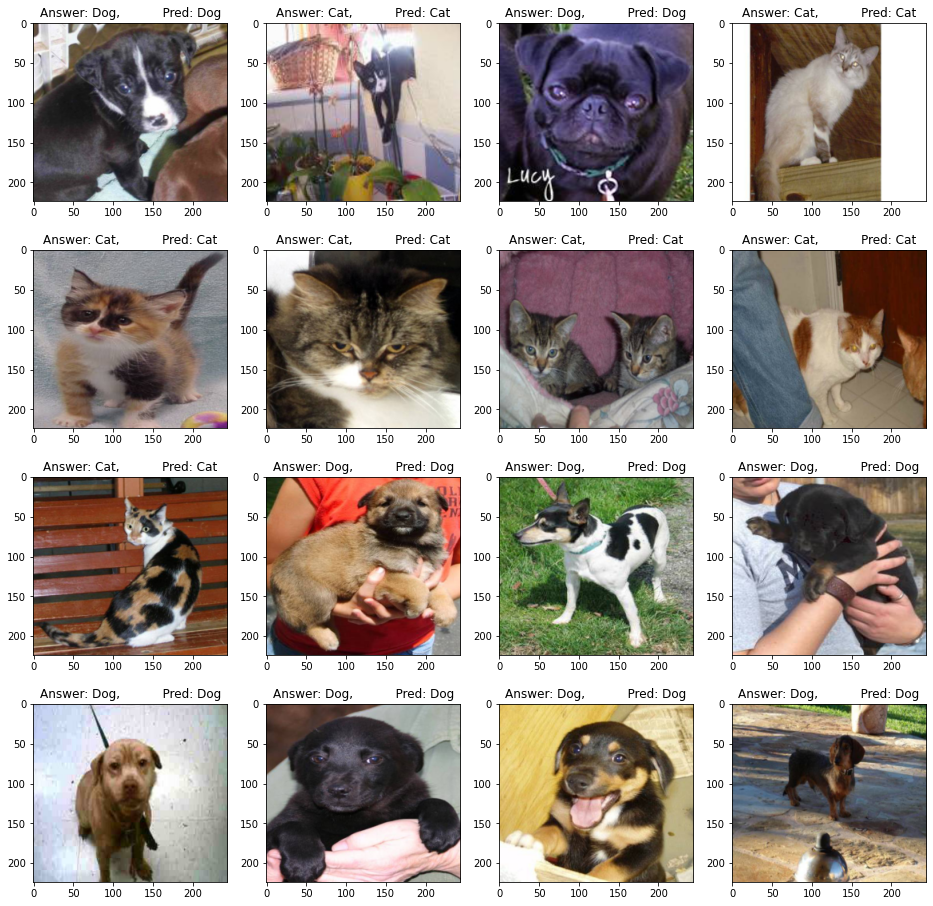

In [64]:
test_func(test_dataloader, model, loss_fn)